In [1]:
from SimPy.Simulation import *
import math
import random
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt

In [2]:
## Model ----------
class Source(Process):
    """generate random arrivals"""

    def run(self, N):
        for i in range(N):
            a = Arrival(str(i))
            activate(a, a.run())
            t = random.expovariate(1 / 58.28008368978102) #time till next arrival
            
            G.interarrivalmon.observe(t)
            G.interarrivalsquaredmon.observe(t ** 2)
            yield hold, self, t


class Arrival(Process):
    """an arrival"""

    def run(self):
        G.inSystem += 1
        G.inQueue += 1
        G.lMon.observe(G.inSystem)
        G.lqMon.observe(G.inQueue)
        arrivetime = now()
        yield request, self, G.server
        
        G.inQueue -= 1
        G.lqMon.observe(G.inQueue)
        G.wqMon.observe(now() - arrivetime)

        # service time
        t = ss.erlang.rvs(round(2.76135310883745), 0, 15.391464912580066)

        G.wsMon.observe(t)
        G.ws2Mon.observe(t ** 2)
        yield hold, self, t
        yield release, self, G.server
        delay = now() - arrivetime
        G.wMon.observe(delay)
        
        G.inSystem -= 1
        G.lMon.observe(G.inSystem)
        
        # print(now(), "Observed queue time", delay - t)
        # print(now(), "Observed delay", delay)


class G:
    inSystem = 0
    inQueue = 0
    
    server = 'dummy'
    wMon = 'Monitor'
    wsMon = 'Monitor'
    ws2Mon = 'Monitor'
    wqMon = 'Monitor'
    lMon = 'Monitor'
    lqMon = 'Monitor'
    
    interarrivalmon = 'Monitor'
    interarrivalsquaredmon = 'Monitor'
    
    serviceTimes = []
    interArrivalTimes = []


def model(N, maxtime, rvseed):
    # setup
    initialize()
    random.seed(rvseed)
    G.inSystem = 0
    G.inQueue = 0
    
    G.server = Resource(1, monitored=True)
    G.wMon = Monitor()
    G.wsMon = Monitor()
    G.ws2Mon = Monitor()
    G.wqMon = Monitor()
    G.lMon = Monitor()
    G.lqMon = Monitor()
    
    G.interarrivalmon = Monitor()
    G.interarrivalsquaredmon = Monitor()

    # simulate
    s = Source('Source')
    activate(s, s.run(N))
    simulate(until=maxtime)

    # gather performance measures
    W = G.wMon.mean()
    Ws = G.wsMon.mean()
    Ws2 = G.ws2Mon.mean()
    Wq = G.wqMon.mean()
    L = G.lMon.timeAverage()
    Lq = G.lqMon.timeAverage()
    
    Svar = G.wsMon.var()
    util = G.server.actMon.timeAverage()
    IA = G.interarrivalmon.mean()
    IAvar = G.interarrivalmon.var()

    #print("Service times:\n")
    #print(G.wsMon.yseries(), "\n")
    # print("Service times squared:\n")
    # print(G.servicesquaredmon.yseries(),"\n")
    
    #print(G.lMon.yseries(), "\n")

    #print("interarival times:\n")
    #print(G.interarrivalmon.yseries())
    G.serviceTimes += G.wsMon.yseries()
    G.interArrivalTimes += G.interarrivalmon.yseries()

    return(W,Ws,Ws2,L,util,IA,Wq,Lq,IAvar,Svar)


## Experiment ----------------
allW = []
allWq = []
allS = []
allL = []
allLq = []
allUtil = []
allIA = []
allIAvar = []
allSvar = []

for i in range(50):
    if i == 9:
        print("Doing", str(i + 1) + "th", "iteration")
    elif i == 19:
        print("Doing", str(i + 1) + "th", "iteration")
    elif i == 29:
        print("Doing", str(i + 1) + "th", "iteration")
    elif i ==39:
        print("Doing", str(i + 1) + "th", "iteration")
        
    result = model(N=30, maxtime=2000000000, rvseed=123*i)
    
    allW.append(result[0])
    allS.append(result[1])
    allL.append(result[3])
    allUtil.append(result[4])
    allIA.append(result[5])
    allWq.append(result[6])
    allLq.append(result[7])
    allIAvar.append(result[8])
    allSvar.append(result[9])

print("")
print("ESTIMATES")
print("---------")
print("Interarrival mean:", np.mean(allIA))
print("W:", np.mean(allW))
print("Wq:", np.mean(allWq))
print("Ws:", np.mean(allS))
print("L:", np.mean(allL))
print("Lq:", np.mean(allLq))
print("Utilisation:", np.mean(allUtil))
print("Interarrival variance:", np.mean(allIAvar))
print("Ws variance:", np.mean(allSvar))

Doing 10th iteration
Doing 20th iteration
Doing 30th iteration
Doing 40th iteration

ESTIMATES
---------
Interarrival mean: 59.748762464805424
W: 106.74094905278471
Wq: 62.56906638559021
Ws: 44.17188266719447
L: 1.8323802432531562
Lq: 1.1022067280907664
Utilisation: 0.7301735151623897
Interarrival variance: 3723.6077844391575
Ws variance: 637.8402921489618


In [3]:
serviceTimes = G.serviceTimes
interArrivalTimes = G.interArrivalTimes

serviceBins = int(round(1 + np.log2(len(serviceTimes))))
interArrivalBins = int(round(1 + np.log2(len(interArrivalTimes))))

Service Times:

[121.33085749958384, 34.18613582956228, 60.43823910023546, 12.201987531659894, 34.30018368111884, 67.51315741683563, 21.48995363544204, 49.19981006614953, 13.685776919477707, 61.30603849074224, 46.99505503537294, 9.867720001767376, 80.6953130240936, 52.110476055798884, 17.456341649637633, 36.33710393772811, 39.99458803336687, 25.097464866142786, 23.391266051052277, 96.63397607580126, 94.03178559277487, 13.649091224246659, 37.859809837853284, 47.66172352918668, 69.92316530763848, 32.08062770298741, 51.50019824266753, 10.226191083576033, 20.42912831300741, 22.383907734324065, 66.21793014636953, 3.3874480860458203, 39.70649893985741, 31.48859083563966, 33.53263047018382, 79.5417951617727, 42.212724444428304, 73.38857057687252, 73.35627847436827, 96.11510538000095, 39.27215397487391, 21.315408735419847, 69.52738658034545, 26.63370468271332, 80.18268565860906, 55.92540082096841, 67.34481709355791, 32.68432925906564, 69.15184138005665, 51.545020057802844, 9.9040872574549, 12.

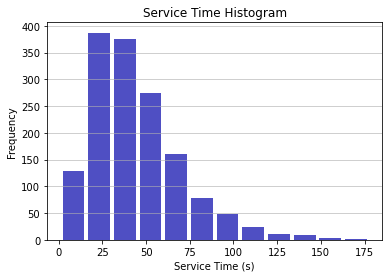

In [4]:
#Service Histogram
plt.hist(x=serviceTimes, bins=serviceBins, color='#0504aa', alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Service Time (s)')
plt.ylabel('Frequency')
plt.title('Service Time Histogram')
plt.plot();

print("Service Times:\n")
print(serviceTimes)

interarival times:

[108.43633814668293, 82.67782575995746, 31.80420779277768, 17.463179032820584, 41.725902734525775, 30.25221153380591, 89.25856189247105, 21.06350878077703, 37.730728386621074, 51.02920431142055, 139.12589339762698, 40.94555293737823, 19.294198210822582, 82.16238390866808, 56.141268557360405, 16.80549470221598, 140.17118919588754, 236.73380689570104, 96.85422622125003, 135.47104090163418, 21.638088017412535, 76.27174927570255, 133.52170765021432, 67.13645449110311, 37.23685460454058, 6.185844551385263, 33.18845871319014, 55.00972132171481, 142.3184617414815, 198.11673654963607, 3.1345589479903673, 5.316535673520709, 30.4786572146926, 6.641198732399625, 134.897781097809, 2.267128891806789, 44.776952706221444, 23.53134755618352, 111.38072540108367, 10.13791142954902, 23.971013677210728, 23.67103537578232, 16.391501651418395, 0.09744141563836252, 33.40556947496315, 5.343793221214931, 53.05278734098366, 4.221716135540731, 22.0885421917441, 34.664423071295445, 137.4293070

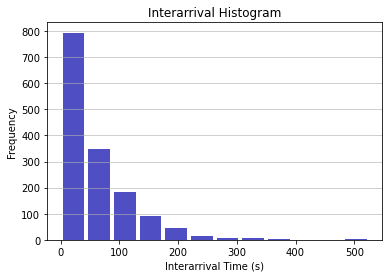

In [5]:
#Interarrival Histogram
plt.hist(x=interArrivalTimes, bins=interArrivalBins, color='#0504aa', alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Interarrival Time (s)')
plt.ylabel('Frequency')
plt.title('Interarrival Histogram')
plt.plot();

print("interarival times:\n")
print(interArrivalTimes)